In [1]:
import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio.plot import show_hist
import pandas as pd
import numpy as np
import rasterio.mask
from rasterio.mask import mask
from shapely.geometry import box
import fiona
from fiona.crs import from_epsg
import os
import matplotlib.pyplot as plt
import numpy as np
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import folium
from osgeo import gdal
from PIL import Image
import tifffile
import matplotlib.pyplot as plt

In [2]:
with fiona.open("Biləsuvar.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

In [6]:
geotiff_path = "subset_S2A_MSIL2A_20221119T074221_s2resampled_reprojected_RGB.tif"
# Open the GeoTIFF file in read mode
with rasterio.open(geotiff_path) as src:
    # Apply the mask
    out_image,transform = mask(src, shapes, crop=True)
    out_meta = src.meta

In [7]:
out_meta.update({"height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": transform})

In [8]:
with rasterio.open("masked.tif", "w", **out_meta) as file:
    file.write(out_image)

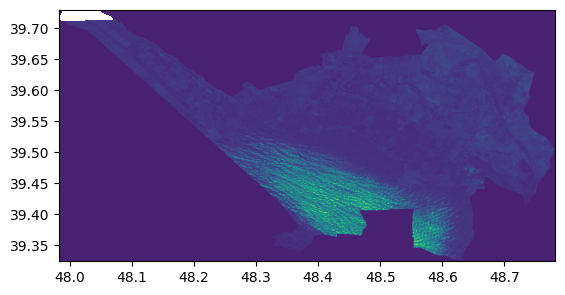

<Axes: >

In [11]:
show(rasterio.open("masked.tif"))

In [12]:
masked_tif.count

12

In [18]:
import warnings
warnings.filterwarnings("ignore")
red_band=out_image[3]
nir_band=out_image[7]
ndvi=(nir_band-red_band)/(nir_band+red_band)

In [19]:
red_band.shape, nir_band.shape

((4364, 8609), (4364, 8609))

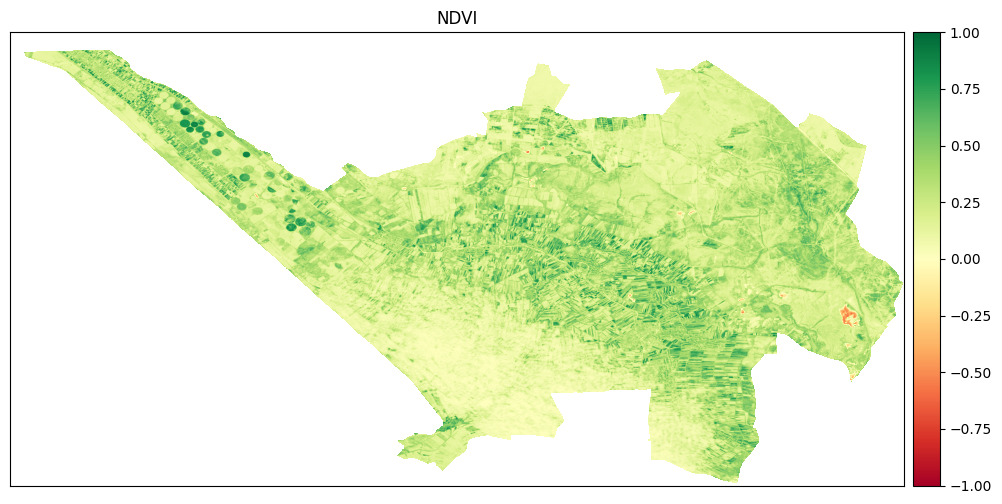

<Axes: title={'center': 'NDVI'}>

In [20]:
ep.plot_bands(ndvi, cmap="RdYlGn", cols=1, title='NDVI', vmin=-1, vmax=1)

In [22]:
height = red_band.shape[0]
width = red_band.shape[1]
cols, rows = np.meshgrid(np.arange(width), np.arange(height))
xs, ys = rasterio.transform.xy(src.transform, rows, cols)
lons= np.array(xs)
lats = np.array(ys)

In [32]:
data = pd.DataFrame({'Lons':lons.flatten(),
                     'Lats':lats.flatten(),
                      'Ndvi':ndvi.flatten()  })

In [33]:
data.head()

,Lons,Lats,Ndvi
0,47.501070,39.728997,NaN
1,47.501162,39.728997,NaN
2,47.501255,39.728997,NaN
3,47.501348,39.728997,NaN
4,47.501441,39.728997,NaN


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37569676 entries, 0 to 37569675
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Lons    float64
 1   Lats    float64
 2   Ndvi    float32
dtypes: float32(1), float64(2)
memory usage: 716.6 MB


In [35]:
data.isnull().sum()

Lons           0
Lats           0
Ndvi    20956033
dtype: int64

In [36]:
data2=data.copy()
data3=data.copy()

In [37]:
data.dropna(inplace=True)
data.isnull().sum()

Lons    0
Lats    0
Ndvi    0
dtype: int64

In [39]:
data=data[data["Ndvi"]>0]

In [40]:
def categorize_ndvi(row):
    thresholds = [0, 0.33, 0.66, 1]
    categories = [0, 1, 2, 3]
    
    for threshold, category in zip(thresholds, categories):
        if row <= threshold:
            return category

In [46]:
ndvi_cat = data2['Ndvi'].apply(categorize_ndvi)

In [47]:
ndvi_cat.shape

(37569676,)

In [48]:
ndvi_cat = ndvi_cat.to_numpy().reshape(red_band.shape)

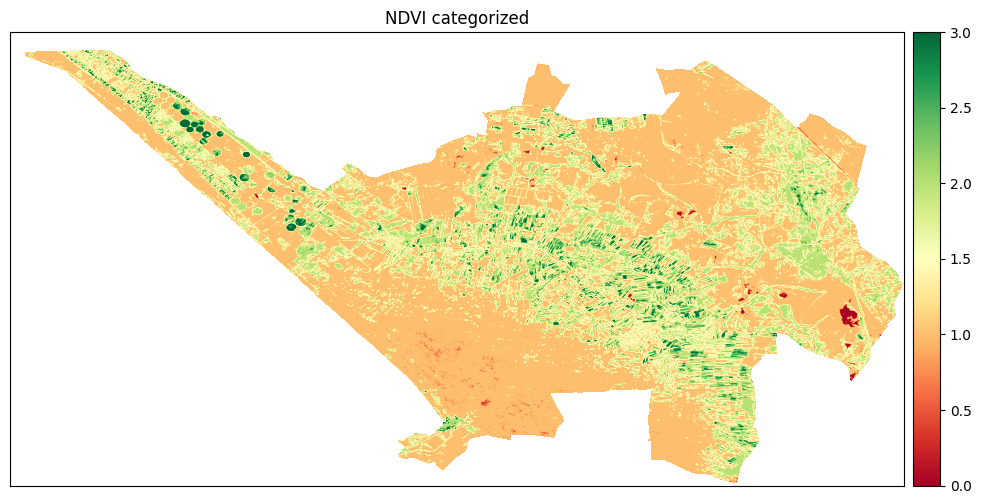

<Axes: title={'center': 'NDVI categorized'}>

In [49]:
ep.plot_bands(ndvi_cat, cmap="RdYlGn", cols=1, title='NDVI categorized')

In [51]:
sample_data = data.sample(20,ignore_index=True)
sample_data

,Lons,Lats,Ndvi
0,47.787408,39.537424,0.114727
1,47.675471,39.584946,0.172126
2,48.000978,39.440802,0.128740
3,48.193479,39.513756,0.250996
4,48.272187,39.524894,0.411958
5,48.174452,39.664211,0.230071
6,48.199791,39.545499,0.429344
7,47.946124,39.441545,0.037831
8,47.987427,39.565919,0.303896
9,47.720394,39.622815,0.542709


In [60]:
m = folium.Map(location=[39.31, 48.65], zoom_start=8, control_scale=True)

# Iterate through the DataFrame to create markers
for index, row in sample_data.iterrows():
    html = f'<br>longs={row["Lons"]},<br>lats={row["Lats"]},<br>NDVI: {row["Ndvi"]}'
    iframe = folium.IFrame(html, width=500, height=500)
    
    popup = folium.Popup(iframe, max_width=500)
    
    marker = folium.Marker([row["Lats"], row["Lons"]], popup=popup).add_to(m)

# Display the map
m.save('map.html')

In [61]:
m